In [155]:
from statsforecast import StatsForecast
from statsforecast.models import (Naive, SeasonalNaive, AutoARIMA, AutoETS, AutoTheta)
from datasetsforecast.losses import mse, mae, smape
from data_loading_finance.loading_data import LoadingData
from ts_tools.tools import tools
import yfinance as yf
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore


from typing import List, Callable
from distributed import Client
from fugue import transform
from fugue_dask import DaskExecutionEngine

import warnings
warnings.filterwarnings("ignore")

In [156]:
# Descargar datos
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'IBM', 'BTC-USD']
Y_df = yf.download(tickers, start='2015-01-01', end='2023-12-31', interval='1mo')['Adj Close']

# Resetear el índice y transformar el DataFrame
Y_df = Y_df.reset_index().melt(id_vars='Date', var_name='unique_id', value_name='y')
Y_df = Y_df.rename(columns={'Date': 'ds'})

# Calcular los retornos
Y_df['y'] = np.log(Y_df['y'].div(Y_df.groupby('unique_id')['y'].shift(1)))
Y_df = Y_df.dropna(subset=['y']).reset_index(drop=True)
Y_df

[*********************100%%**********************]  8 of 8 completed


,ds,unique_id,y
0,2015-02-01,AAPL,0.092077
1,2015-03-01,AAPL,-0.027935
2,2015-04-01,AAPL,0.005769
3,2015-05-01,AAPL,0.040173
4,2015-06-01,AAPL,-0.033770
...,...,...,...
851,2023-08-01,NVDA,0.054674
852,2023-09-01,NVDA,-0.126301
853,2023-10-01,NVDA,-0.064464
854,2023-11-01,NVDA,0.137050


In [157]:
season_length = 12
horizon = 3

models = [
    Naive(),
    AutoETS(season_length=season_length),
    AutoTheta(season_length=season_length),
    AutoARIMA(season_length=season_length),
    SeasonalNaive(season_length=season_length),
]

# Instantiate StatsForecast class with models, data frequency ('MS' for monthly),
# and parallel computation on all CPU cores (n_jobs=-1)
sf = StatsForecast(
    models=models, # models for forecasting
    freq='MS',  # frequency of the data
    n_jobs=1  # number of jobs to run in parallel, -1 means using all processors
)

In [158]:
# Generate forecasts for the specified horizon using the sf object
Y_hat_df = sf.forecast(df=Y_df, h=horizon) # forecast data
Y_hat_df.head() 

,ds,Naive,AutoETS,AutoTheta,AutoARIMA,SeasonalNaive
unique_id,,,,,,
AAPL,2024-01-01,0.014808,0.018681,0.015919,0.0,0.104829
AAPL,2024-02-01,0.014808,0.018681,0.015919,0.0,0.021393
AAPL,2024-03-01,0.014808,0.018681,0.015919,0.0,0.113647
AMZN,2024-01-01,0.039263,0.020148,0.019798,0.0,0.205174
AMZN,2024-02-01,0.039263,0.020148,0.019798,0.0,-0.090252


In [159]:
cv_df = sf.cross_validation(df=Y_df, h=horizon, n_windows=5, step_size=horizon, level=[90])
cv_df.head()

,ds,cutoff,y,Naive,Naive-lo-90,Naive-hi-90,AutoETS,AutoETS-lo-90,AutoETS-hi-90,AutoTheta,AutoTheta-lo-90,AutoTheta-hi-90,AutoARIMA,AutoARIMA-lo-90,AutoARIMA-hi-90,SeasonalNaive,SeasonalNaive-lo-90,SeasonalNaive-hi-90
unique_id,,,,,,,,,,,,,,,,,,
AAPL,2022-10-01,2022-09-01,0.103956,-0.127556,-0.311250,0.056137,0.018053,-0.119826,0.155933,-0.002664,-0.131205,0.159468,0.0,-0.138050,0.138050,0.057001,-0.129833,0.243836
AAPL,2022-11-01,2022-09-01,-0.035243,-0.127556,-0.387338,0.132226,0.018053,-0.119826,0.155933,-0.002664,-0.150728,0.118957,0.0,-0.138050,0.138050,0.098461,-0.088374,0.285296
AAPL,2022-12-01,2022-09-01,-0.128762,-0.127556,-0.445723,0.190610,0.018053,-0.119826,0.155933,-0.002664,-0.179930,0.132992,0.0,-0.138050,0.138050,0.073062,-0.113773,0.259896
AAPL,2023-01-01,2022-12-01,0.104829,-0.128762,-0.315894,0.058371,0.016876,-0.122136,0.155888,-0.009569,-0.138865,0.153514,0.0,-0.138821,0.138821,-0.015837,-0.204590,0.172916
AAPL,2023-02-01,2022-12-01,0.021393,-0.128762,-0.393407,0.135883,0.016876,-0.122136,0.155888,-0.009569,-0.158503,0.112765,0.0,-0.138821,0.138821,-0.056855,-0.245609,0.131898


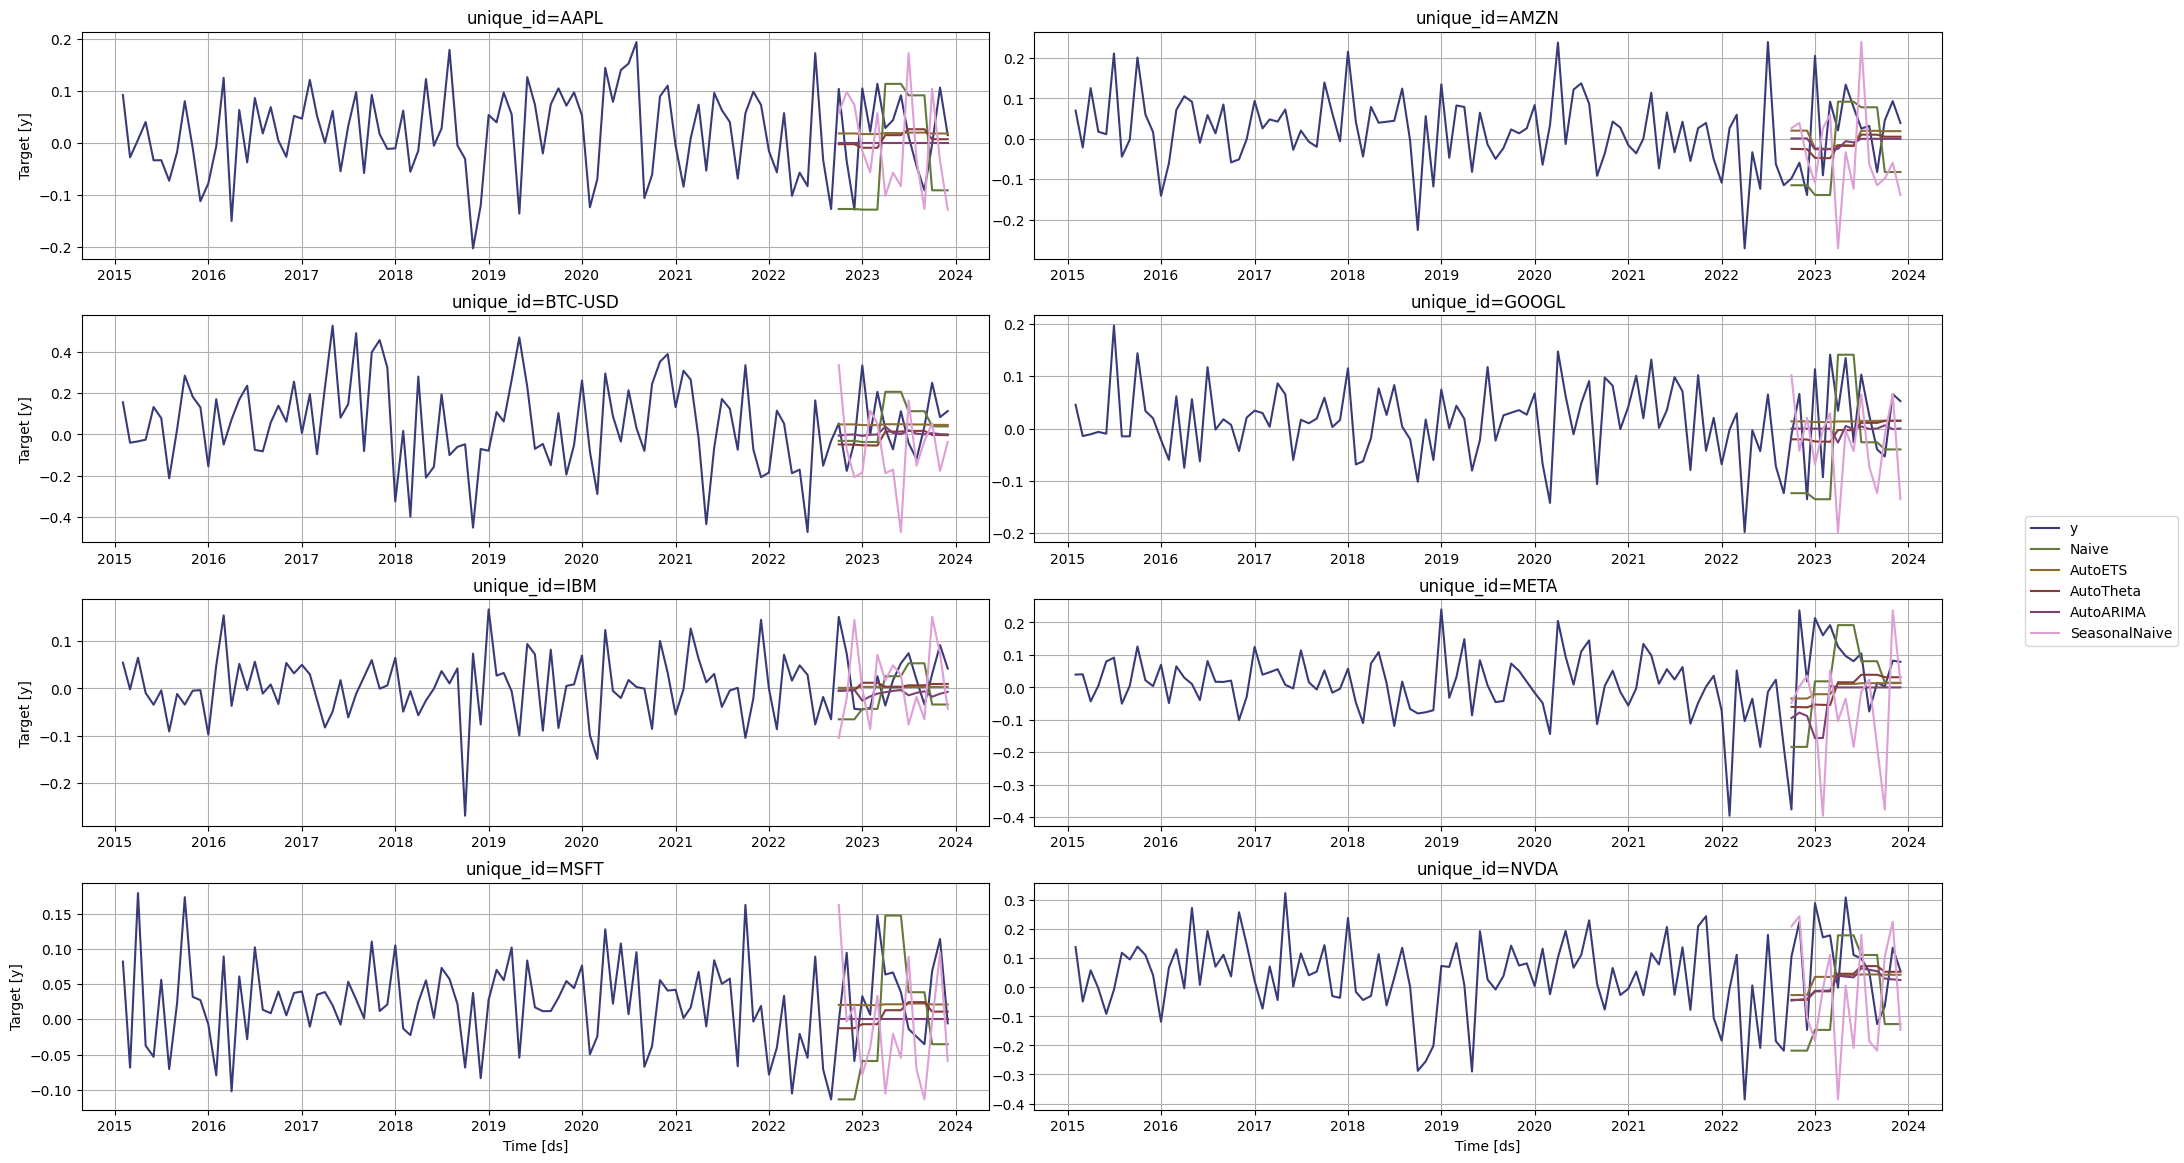

In [160]:
StatsForecast.plot(Y_df, cv_df.drop(['cutoff', 'y'], axis=1))

In [161]:
cv_df = pd.DataFrame(cv_df)
cv_df.index.name = 'unique_id'

# Transformar índice en columna
cv_df.reset_index(inplace=True)

In [162]:
def evaluate(df: pd.DataFrame, metrics: List[Callable]) -> pd.DataFrame:
    eval_ = {}
    models = df.loc[:, ~df.columns.str.contains('unique_id|y|ds|cutoff|lo|hi')].columns
    for model in models:
        eval_[model] = {}
        for metric in metrics:
            eval_[model][metric.__name__] = metric(df['y'], df[model])
    eval_df = pd.DataFrame(eval_).rename_axis('metric').reset_index()
    eval_df.insert(0, 'cutoff', df['cutoff'].iloc[0])
    eval_df.insert(0, 'unique_id', df['unique_id'].iloc[0])
    return eval_df

In [163]:
str_models = cv_df.loc[:, ~cv_df.columns.str.contains('unique_id|y|ds|cutoff|lo|hi')].columns
str_models = ','.join([f"{model}:float" for model in str_models])
cv_df['cutoff'] = cv_df['cutoff'].astype(str)
cv_df['unique_id'] = cv_df['unique_id'].astype(str)

In [164]:
client = Client() # without this, dask is not in distributed mode
# fugue.dask.dataframe.default.partitions determines the default partitions for a new DaskDataFrame
engine = DaskExecutionEngine({"fugue.dask.dataframe.default.partitions": 96})

In [165]:
evaluation_df = transform(
    cv_df.loc[:, ~cv_df.columns.str.contains('lo|hi')], 
    evaluate, 
    engine="dask",
    params={'metrics': [mse, mae, smape]}, 
    schema=f"unique_id:str,cutoff:str,metric:str, {str_models}", 
    as_local=True,
    partition={'by': ['unique_id', 'cutoff']}
)
evaluation_df.head()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask

2024-07-16 15:24:27,536 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 35d36101e74e019ab221a29040334273 initialized by task ('shuffle-transfer-35d36101e74e019ab221a29040334273', 2) executed on worker tcp://127.0.0.1:56205
2024-07-16 15:24:31,807 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 35d36101e74e019ab221a29040334273 deactivated due to stimulus 'task-finished-1721136271.798548'


,unique_id,cutoff,metric,Naive,AutoETS,AutoTheta,AutoARIMA,SeasonalNaive
0,AAPL,2022-12-01,mse,0.045291,0.005707,0.009743,0.008121,0.007958
1,AAPL,2022-12-01,mae,0.208718,0.06308,0.089526,0.079956,0.085135
2,AAPL,2022-12-01,smape,200.0,105.474678,200.0,200.0,155.38269
3,AAPL,2023-06-01,mse,0.01942,0.005522,0.006351,0.00351,0.009022
4,AAPL,2023-06-01,mae,0.132679,0.060872,0.067343,0.049624,0.069237


In [166]:
# Calculate the mean metric for each cross validation window
evaluation_df.groupby(['cutoff', 'metric']).mean(numeric_only=True)

Naive     AutoETS   AutoTheta   AutoARIMA  \
cutoff     metric                                                   
2022-09-01 mae       0.140707    0.116819    0.107904    0.113134   
           mse       0.034612    0.020543    0.018394    0.019228   
           smape   122.638107  179.345764  154.407425  191.849564   
2022-12-01 mae       0.187454    0.119316    0.146654    0.140327   
           mse       0.049851    0.020651      0.0317    0.031477   
           smape   165.745575  154.682541  185.422333  184.897934   
2023-03-01 mae       0.090087    0.068308    0.069374    0.076034   
           mse       0.012033    0.007825    0.007815    0.008699   
           smape      92.5149  139.819473  150.675079  182.969986   
2023-06-01 mae       0.091578     0.05855    0.059201     0.05461   
           mse         0.0126    0.005689     0.00561    0.004754   
           smape   143.840286  138.923187   144.90831  182.017548   
2023-09-01 mae       0.106766    0.057548    0.064111    0.071312   
           mse        0.01534    0.005121    0.006829     0.00759   
           smape    164.35228   127.29567  146.268219  191.319977   

                   SeasonalNaive  
cutoff     metric                 
2022-09-01 mae          0.135725  
           mse          0.024705  
           smape      151.663605  
2022-12-01 mae            0.1665  
           mse          0.050057  
           smape      158.108078  
2023-03-01 mae           0.18533  
           mse          0.050736  
           smape      178.183319  
2023-06-01 mae          0.097938  
           mse          0.013699  
           smape      132.440872  
2023-09-01 mae          0.130567  
           mse          0.023997  
           smape      152.705444

<Axes: xlabel='error', ylabel='model'>

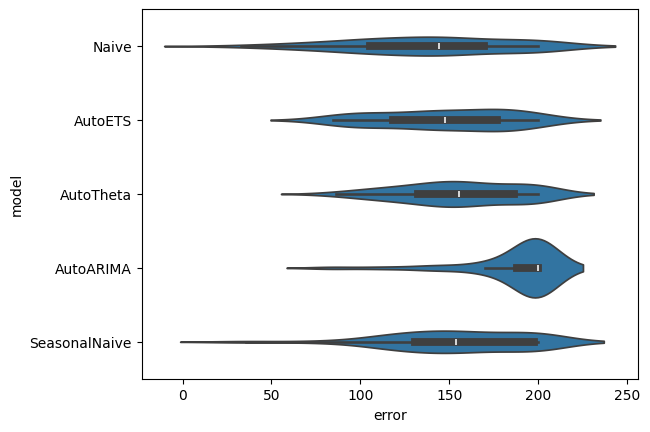

In [167]:
evaluation_df_melted = pd.melt(evaluation_df, id_vars=['unique_id', 'cutoff', 'metric'], var_name='model', value_name='error')
sns.violinplot(evaluation_df_melted.query('metric=="smape"'), x='error', y='model')

<Axes: xlabel='n', ylabel='best_model'>

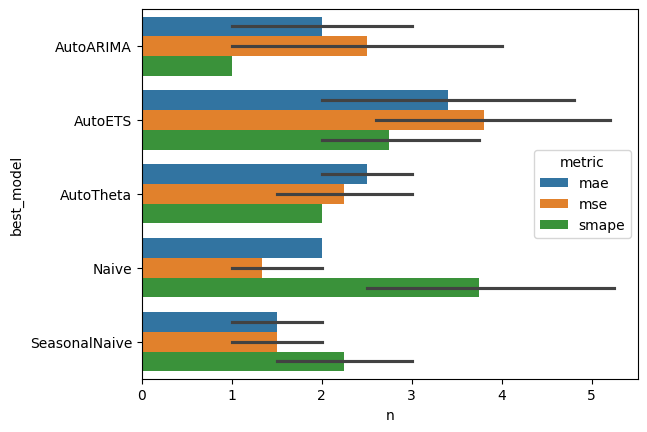

In [168]:
# Choose the best model for each time series, metric, and cross validation window
evaluation_df['best_model'] = evaluation_df.idxmin(axis=1, numeric_only=True)
# count how many times a model wins per metric and cross validation window
count_best_model = evaluation_df.groupby(['cutoff', 'metric', 'best_model']).size().rename('n').to_frame().reset_index()
# plot results
sns.barplot(count_best_model, x='n', y='best_model', hue='metric')